<a href="https://colab.research.google.com/github/itsGab/bootcamp_df_covid_prophet/blob/main/nb/covid_curitiba_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[boletim epidemiologico covid 19 pr - 2021-06-19](https://www.saude.pr.gov.br/sites/default/arquivos_restritos/files/documento/2021-06/informe_epidemiologico_19_06_2021.pdf)

Importacão dos pacotes

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Abrindo os dados

In [8]:
dados = '/content/drive/MyDrive/Bootcamp Data Science Aplicada 2 Alura/dados full covid 19/caso_full.csv'
covid = pd.read_csv(dados)

Mudando o nome das colunas e fazendo o tratamento

In [9]:
traduz = {
    'city': 'cidade', 
    'city_ibge_code': 'cod_ibge_cidade', 
    'date': 'datahora', 
    'epidemiological_week': 'semana_epidemiologica',
    'estimated_population': 'populacao_estimada', 
    'estimated_population_2019': 'populacao_estimada_2019', 
    'is_last': 'eh_ultimo',
    'is_repeated': 'eh_repetido', 
    'last_available_confirmed': 'ultimo_disponivel_confirmado',
    'last_available_confirmed_per_100k_inhabitants': 'ultimo_disponivel_confirmado_por_100mil_habitantes', 
    'last_available_date': 'ultimo_disponivel_datahora',
    'last_available_death_rate': 'ultimo_disponivel_taxa_mortalidade', 
    'last_available_deaths': 'ultimo disponivel obitos', 
    'order_for_place': 'ordem_por_lugar',
    'place_type': 'tipo_de_lugar', 
    'state': 'estado', 
    'new_confirmed': 'casos_novos', 
    'new_deaths': 'obitos_novos'
}

covid.columns = covid.columns.map(traduz)
covid['tipo_de_lugar'] = covid['tipo_de_lugar'].map(traduz)
covid['datahora'] = pd.to_datetime(covid['datahora'])
covid['mes'] = covid['datahora'].dt.month
covid['dia'] = covid['datahora'].dt.day
covid['ano'] = covid['datahora'].dt.year
covid.head()

,cidade,cod_ibge_cidade,datahora,semana_epidemiologica,populacao_estimada,populacao_estimada_2019,eh_ultimo,eh_repetido,ultimo_disponivel_confirmado,ultimo_disponivel_confirmado_por_100mil_habitantes,ultimo_disponivel_datahora,ultimo_disponivel_taxa_mortalidade,ultimo disponivel obitos,ordem_por_lugar,tipo_de_lugar,estado,casos_novos,obitos_novos,mes,dia,ano
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,cidade,AC,3,0,3,17,2020
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,estado,AC,3,0,3,17,2020
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,cidade,AC,0,0,3,18,2020
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,estado,AC,0,0,3,18,2020
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,cidade,AC,1,0,3,19,2020


Criando e selecionando dataframes

In [48]:
tudo_pr = covid[covid['estado'] == 'PR'] # todos os dados PR
cidade_pr = tudo_pr[tudo_pr['tipo_de_lugar'] == 'cidade'] # todas as cidade PR
uf_pr = tudo_pr[tudo_pr['tipo_de_lugar'] == 'estado'] # só o estado PR
ctba = covid[covid['cidade'] == 'Curitiba'] # só Curitiba PR

In [49]:
ctba['casos_acumulados'] = ctba['casos_novos'].cumsum() # acumulado
ctba['casos_media_movel'] = ctba['casos_novos'].rolling(7, center=False).mean() # media movel 7 dias
ctba['datahora'] = pd.to_datetime(ctba['datahora']) # para datetime

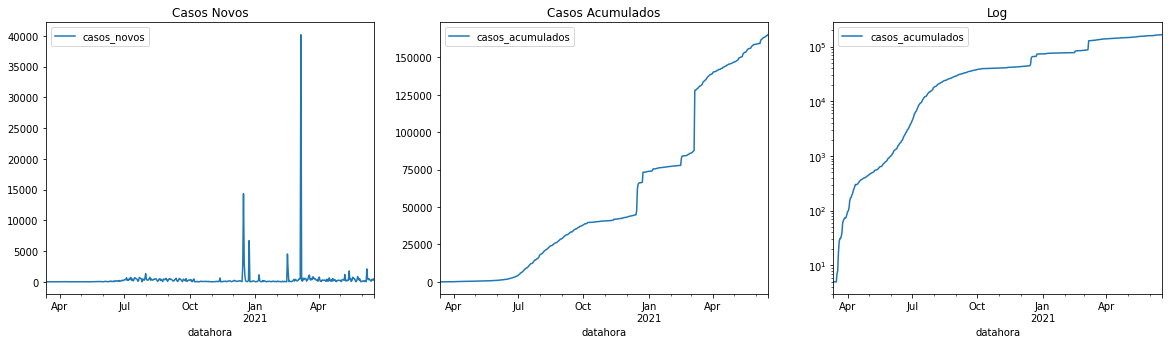

In [43]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

ctba.plot('datahora', 'casos_novos', ax=ax[0], title='Casos Novos')
ctba.plot('datahora', 'casos_acumulados', ax=ax[1], title='Casos Acumulados')
ctba.plot('datahora', 'casos_acumulados', ax=ax[2], title='Log')
mpl.pyplot.yscale('log')

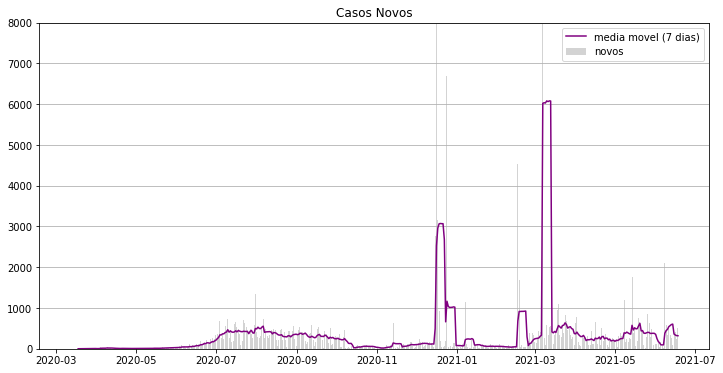

In [60]:
plt.figure(figsize=(12,6))
plt.bar('datahora', 'casos_novos', data=ctba, color='lightgrey', label='novos')
plt.plot('datahora', 'casos_media_movel', data=ctba, color='purple', label='media movel (7 dias)')
plt.ylim(0, 8000)
plt.grid(axis='y')
plt.legend()
plt.title('Casos Novos')
plt.show()

O grafico tem valores muito fora da curva no periodos proximo a dezembro de 2020 e março de 2021, isso pode ser por causa de casos que foram registrados atrasados nessa data

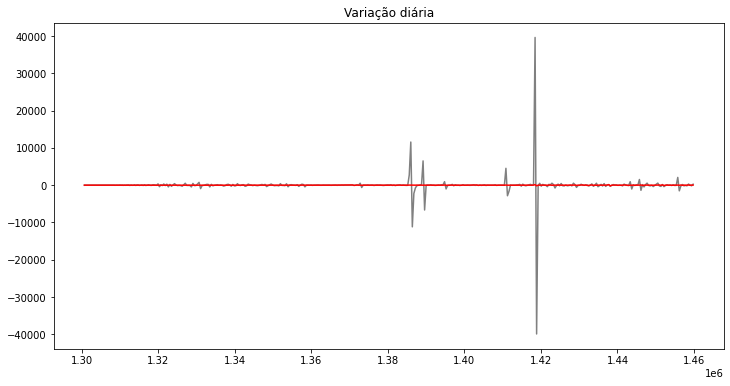

In [64]:
plt.figure(figsize=(12,6))
ctba['casos_novos'].diff().plot(color='grey', label='casos novos')
ctba['obitos_novos'].diff().plot(color='red', label='obitos novos')
plt.title('Variação diária')
plt.show()

In [65]:
def cria_df(df_base, col_ds: str, col_y: str):
    df = pd.DataFrame({'ds': pd.to_datetime(df_base[col_ds]), 'y': df_base[col_y]})
    return df

In [66]:
def cria_modelo(df_prophet, periodo=30, modelo=None):
    if modelo == None:
        modelo = Prophet()
    modelo.fit(df_prophet)
    future = modelo.make_future_dataframe(periodo)
    forcast = modelo.predict(future)
    return modelo, future, forcast

[fonte](http://www.coronavirus.pr.gov.br/vacinacao-ranking) da porcentagem de vacinados em curitiba

In [69]:
df = cria_df(ctba, 'datahora', 'casos_novos')
df.head()

,ds,y
1300681,2020-03-12,5
1300684,2020-03-13,0
1300687,2020-03-14,0
1300690,2020-03-15,0
1300693,2020-03-16,0


In [107]:
df = cria_df(ctba, 'datahora', 'casos_novos')
df['y'] = ctba['casos_novos'].mask(ctba['casos_novos'] > 5000) # tirando outliers
df.head()

,ds,y
1300681,2020-03-12,5.0
1300684,2020-03-13,0.0
1300687,2020-03-14,0.0
1300690,2020-03-15,0.0
1300693,2020-03-16,0.0


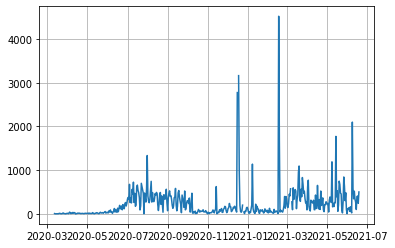

In [108]:
plt.plot('ds', 'y', data=df)
plt.grid()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


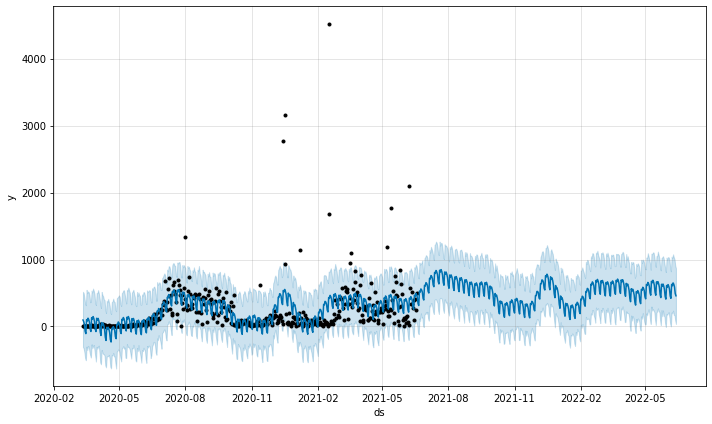

In [134]:
# criar modelo prophet
m = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True).fit(df) # supondo que haja uma sazon. anual
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


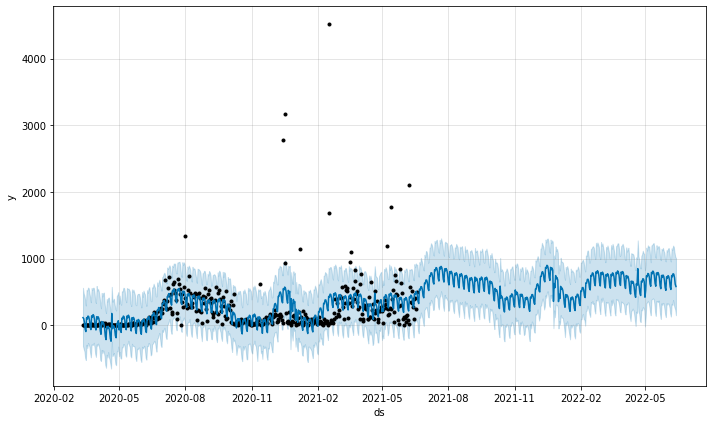

In [136]:
# criar modelo prophet com holidays

m = Prophet(yearly_seasonality=True) # supondo que haja uma sazon. anual
m.add_country_holidays('BR')
m.fit(df)
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);

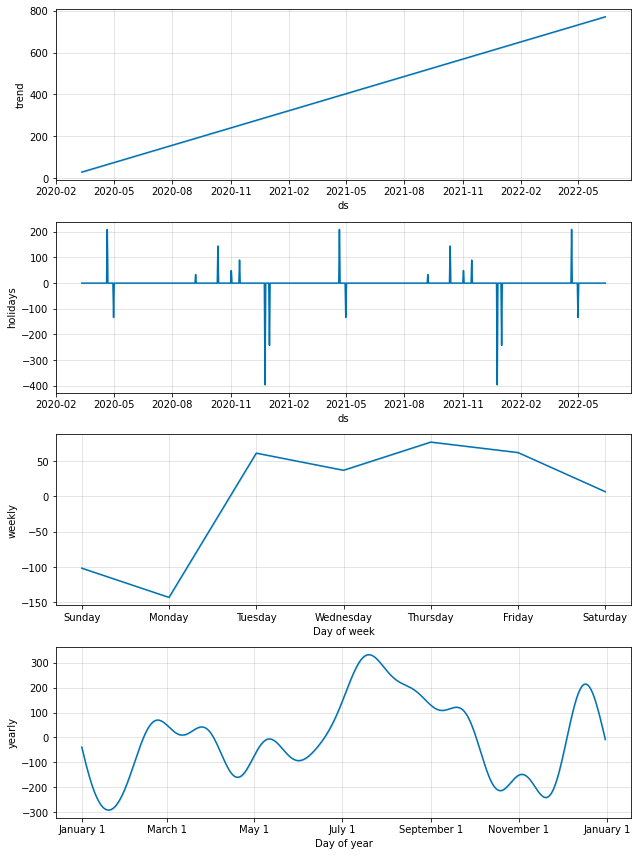

In [137]:
from fbprophet.plot import plot_components

m.plot_components(fcst);